In [1]:
%matplotlib inline
%load_ext autotime
%load_ext snakeviz
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import datetime as dt
from SIR_models import *
import datetime as dt

# Modelling the COVID spread with a SIR model


$$\frac{dS}{dt} = -\beta IS$$

$$\frac{dI}{dt} = \beta IS-\gamma I$$

$$\frac{dR}{dt} = \gamma I$$

Beta:0.26824145855983644 Gamma:0.01304273316407611
R0:20.566353323754246
Predicting with Beta:0.26824145855983644 Beta2: 0.26824145855983644 Gamma:0.01304273316407611


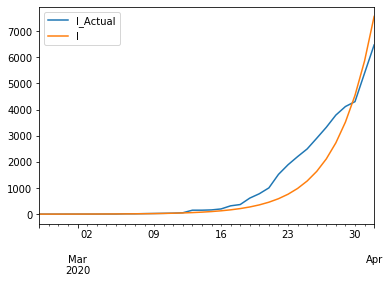

time: 609 ms


In [2]:
#%%snakeviz ## BETA3
trained = SIR('Brazil', N=200e6,alpha=0.7)
#out = jap.train()
#jap.estimate()
out = trained.train()
#out = Trained.predict(beta=0.20,gamma=0.07)
trained.I_fit_plot()

Beta:0.3444472364966636 Beta2: 0.15309285675478698 Gamma:1e-08
R0:34444723.64966636
Predicting with Beta:0.3444472364966636 Beta2: 0.15309285675478698 Gamma:1e-08


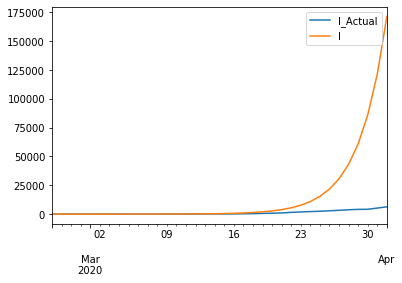

time: 964 ms


In [3]:
#%%snakeviz ## BETA3
#custom = SIR.Learner('Brazil', N=200e6,alpha=0.7,forcedBeta=0.3)
#custom = SIR.Learner('Brazil', N=200e6,alpha=0.7,forcedGamma=0.07)
#custom = SIR.Learner('Brazil', N=200e6,alpha=0.7,forcedBeta = 0.20,forcedGamma=0.07, daysPredict = 30,nth=1)
custom = SIR('Brazil', N=200e6, alpha=0.7, forcedGamma=0.07, daysPredict=30, 
                     nth=1, estimateBeta2=True, quarantineDate=dt.datetime(2020,3,15))
custom = SIR('Brazil', N=200e6, alpha=0.7, daysPredict=30, 
                     nth=1, estimateBeta2=True, recoveredAssumption = 2, quarantineDate=dt.datetime(2020,3,15))

#out = jap.train()
#jap.estimate()
out = custom.train()
#out = custom.predict(beta=0.20,gamma=0.07)
#out = custom.predict(beta=0.20,gamma=None)
custom.I_fit_plot()

In [4]:
0.16/0.01

16.0

time: 2 ms


In [5]:
nonl = custom.df
nonl

,I_Actual,R_Actual,S,I,R
2020-02-26,1.0,0.0,2.000000e+08,1.000000e+00,0.000000e+00
2020-02-27,1.0,0.0,2.000000e+08,1.411211e+00,1.193828e-08
2020-02-28,1.0,0.0,2.000000e+08,1.991696e+00,2.879094e-08
2020-02-29,2.0,0.0,2.000000e+08,2.810188e+00,5.255343e-08
2020-03-01,2.0,0.0,2.000000e+08,3.965140e+00,8.608403e-08
...,...,...,...,...,...
2020-08-24,NaN,NaN,1.118623e+00,1.999998e+08,2.436907e+02
2020-08-25,NaN,NaN,9.600383e-01,1.999998e+08,2.456907e+02
2020-08-26,NaN,NaN,8.236955e-01,1.999998e+08,2.476907e+02
2020-08-27,NaN,NaN,7.067631e-01,1.999997e+08,2.496907e+02


time: 18 ms


In [6]:
custom.predict_linear()
l = custom.df
l

Predicting with Beta:0.3444472364966636 Beta2: 0.15309285675478698 Gamma:1e-08


,I_Actual,R_Actual,S,I,R
2020-02-26,1.0,0.0,2.000000e+08,1.000000e+00,0.000000e+00
2020-02-27,1.0,0.0,2.000000e+08,1.344447e+00,1.000000e-08
2020-02-28,1.0,0.0,2.000000e+08,1.807538e+00,2.344447e-08
2020-02-29,2.0,0.0,2.000000e+08,2.430140e+00,4.151986e-08
2020-03-01,2.0,0.0,2.000000e+08,3.267195e+00,6.582125e-08
...,...,...,...,...,...
2020-08-24,NaN,NaN,5.230486e+00,1.999998e+08,2.108091e+02
2020-08-25,NaN,NaN,4.429737e+00,1.999998e+08,2.128091e+02
2020-08-26,NaN,NaN,3.751577e+00,1.999998e+08,2.148091e+02
2020-08-27,NaN,NaN,3.177238e+00,1.999998e+08,2.168091e+02


time: 15 ms


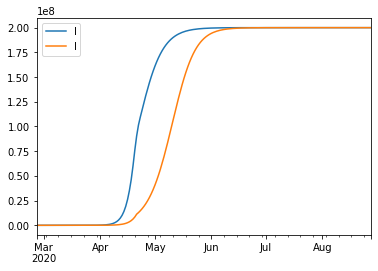

time: 222 ms


In [7]:
pd.DataFrame([nonl["I"],l["I"]]).T.plot()

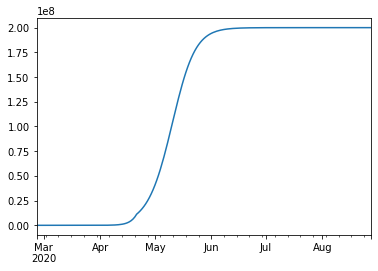

time: 193 ms


In [8]:
l["I"].plot()

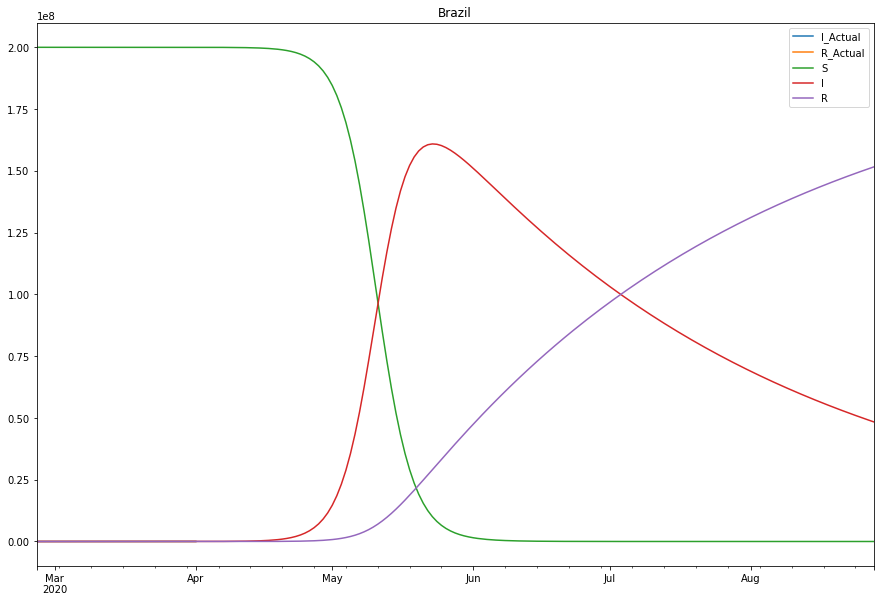

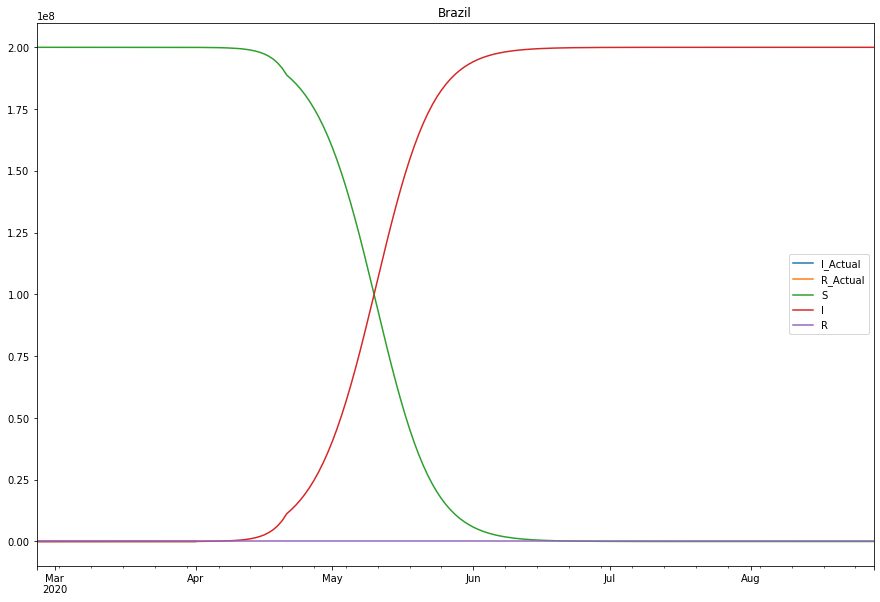

time: 553 ms


In [9]:
trained.main_plot()
custom.main_plot()

In [10]:
#(custom.df - trained.df)
custom.df

,I_Actual,R_Actual,S,I,R
2020-02-26,1.0,0.0,2.000000e+08,1.000000e+00,0.000000e+00
2020-02-27,1.0,0.0,2.000000e+08,1.344447e+00,1.000000e-08
2020-02-28,1.0,0.0,2.000000e+08,1.807538e+00,2.344447e-08
2020-02-29,2.0,0.0,2.000000e+08,2.430140e+00,4.151986e-08
2020-03-01,2.0,0.0,2.000000e+08,3.267195e+00,6.582125e-08
...,...,...,...,...,...
2020-08-24,NaN,NaN,5.230486e+00,1.999998e+08,2.108091e+02
2020-08-25,NaN,NaN,4.429737e+00,1.999998e+08,2.128091e+02
2020-08-26,NaN,NaN,3.751577e+00,1.999998e+08,2.148091e+02
2020-08-27,NaN,NaN,3.177238e+00,1.999998e+08,2.168091e+02


time: 12 ms


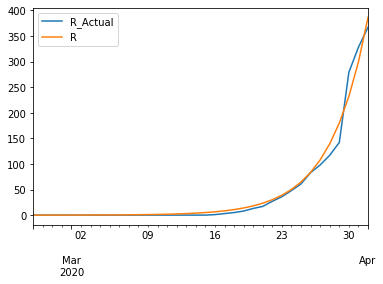

time: 221 ms


In [11]:
trained.R_fit_plot()

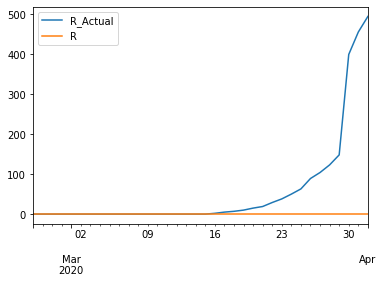

time: 202 ms


In [12]:
custom.R_fit_plot()

# Sensitivity Analysis

## Sensitivity to nth

In [13]:
t1 = SIR('Brazil', N=200e6, alpha=0.7)
t1.train()

Beta:0.26824145855983644 Gamma:0.01304273316407611
R0:20.566353323754246
Predicting with Beta:0.26824145855983644 Beta2: 0.26824145855983644 Gamma:0.01304273316407611
time: 395 ms


In [14]:
t2 = SIR('Brazil', N=200e6, alpha=0.7, nth=100)
t2.train()

Beta:0.21259851891256004 Gamma:0.010466877703397576
R0:20.31155086903805
Predicting with Beta:0.21259851891256004 Beta2: 0.21259851891256004 Gamma:0.010466877703397576
time: 356 ms


In [15]:
t2 = SIR('Brazil', N=200e6, alpha=0.7, nth=150)
t2.train()

Beta:0.21259851891256004 Gamma:0.010466877703397576
R0:20.31155086903805
Predicting with Beta:0.21259851891256004 Beta2: 0.21259851891256004 Gamma:0.010466877703397576
time: 289 ms


In [16]:
t2 = SIR('Brazil', N=200e6, alpha=0.7, nth=1000)
t2.train()

Beta:0.18540375642813173 Gamma:0.014308789206119221
R0:12.957333688921976
Predicting with Beta:0.18540375642813173 Beta2: 0.18540375642813173 Gamma:0.014308789206119221
time: 185 ms


## Sensitivity to infected assumption

In [17]:
t1 = SIR('Brazil', N=200e6, alpha=0.7, infectedAssumption=1)
t1.train()

Beta:0.26824145855983644 Gamma:0.01304273316407611
R0:20.566353323754246
Predicting with Beta:0.26824145855983644 Beta2: 0.26824145855983644 Gamma:0.01304273316407611
time: 371 ms


In [18]:
t1 = SIR('Brazil', N=200e6, alpha=0.7, infectedAssumption=2)
t1.train()

Beta:0.2641785497023327 Gamma:0.008470405224162371
R0:31.188419291764994
Predicting with Beta:0.2641785497023327 Beta2: 0.2641785497023327 Gamma:0.008470405224162371
time: 383 ms


In [19]:
t1 = SIR('Brazil', N=200e6, alpha=0.7, infectedAssumption=3)
t1.train()

Beta:0.2628557371931689 Gamma:0.006978381150102361
R0:37.66715109697229
Predicting with Beta:0.2628557371931689 Beta2: 0.2628557371931689 Gamma:0.006978381150102361
time: 462 ms


In [20]:
t1 = SIR('Brazil', N=200e6, alpha=0.7, infectedAssumption=4)
t1.train()

Beta:0.26225384204446883 Gamma:0.006291904612365689
R0:41.681153514160506
Predicting with Beta:0.26225384204446883 Beta2: 0.26225384204446883 Gamma:0.006291904612365689
time: 350 ms


## Sensitivity to population

In [21]:
t1 = SIR('Brazil', N=200e6, alpha=0.7,)
t1.train()

Beta:0.26824145855983644 Gamma:0.01304273316407611
R0:20.566353323754246
Predicting with Beta:0.26824145855983644 Beta2: 0.26824145855983644 Gamma:0.01304273316407611
time: 380 ms


In [22]:
t1 = SIR('Brazil', N=150e6, alpha=0.7,)
t1.train()

Beta:0.26945146737579573 Gamma:0.014416507310891334
R0:18.69048179042863
Predicting with Beta:0.26945146737579573 Beta2: 0.26945146737579573 Gamma:0.014416507310891334
time: 306 ms


In [23]:
t1 = SIR('Brazil', N=100e6, alpha=0.7,)
t1.train()

Beta:0.2702834915153625 Gamma:0.015285060114061966
R0:17.682854336091673
Predicting with Beta:0.2702834915153625 Beta2: 0.2702834915153625 Gamma:0.015285060114061966
time: 421 ms


In [24]:
t1 = SIR('Brazil', N=50e6, alpha=0.7,)
t1.train()

Beta:0.2682441774120608 Gamma:0.013042280216963128
R0:20.567276039904087
Predicting with Beta:0.2682441774120608 Beta2: 0.2682441774120608 Gamma:0.013042280216963128
time: 395 ms


# SEIR Comparison

Beta:0.26824145855983644 Gamma:0.01304273316407611
R0:20.566353323754246
Predicting with Beta:0.26824145855983644 Beta2: 0.26824145855983644 Gamma:0.01304273316407611


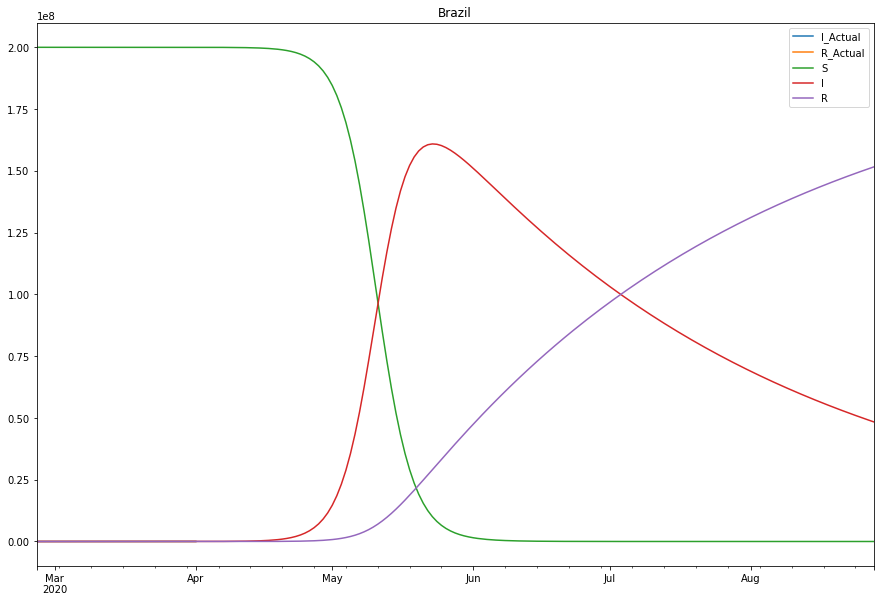

time: 665 ms


In [25]:
seir = SIR('Brazil', N=200e6, alpha=0.7)
seir.train()
seir.main_plot()

Beta:0.4394408166465354 Gamma:0.07 Sigma:0.2013735252041161
R0:6.277725952093363
Predicting with Beta:0.4394408166465354 Beta2: 0.4394408166465354 Gamma:0.07 Sigma:0.2013735252041161


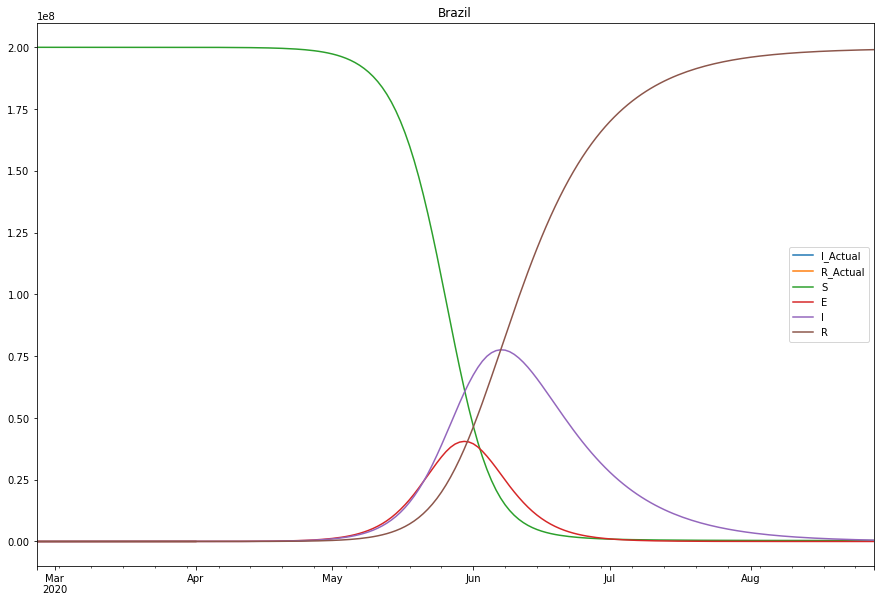

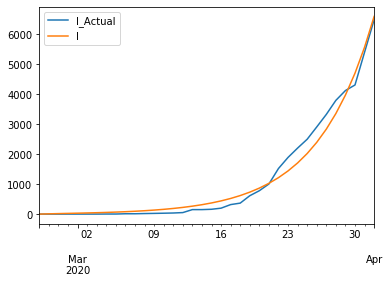

time: 1.4 s


In [26]:
seir = LearnerSEIR('Brazil', N=200e6, alpha=0.7, elag=15, forcedGamma = 0.07)
seir.train()
seir.main_plot()
seir.I_fit_plot()

## Constrained optimization - SEIR

* Tentar colocar os confirmados uma parte no incubados
* tentar falar que 1/3 dos confirmados tao incubados (ou alguma premissa) - talvez nao pq aqui mal estao testando
* calibrar o período de incubação

WHO:
>The “incubation period” means the time between catching the virus and beginning to have symptoms of the disease. Most estimates of the incubation period for COVID-19 range from 1-14 days, most commonly around five days. These estimates will be updated as more data become available. So from 5 to 7.Or 6 if 5 is common. (Inverse of sigma)

Beta:1.0953524472792613 Gamma:0.012788226347090374
R0:85.65319517733435
Predicting with Beta:1.0953524472792613 Beta2: 1.0953524472792613 Gamma:0.012788226347090374 Sigma:0.08333333333333333


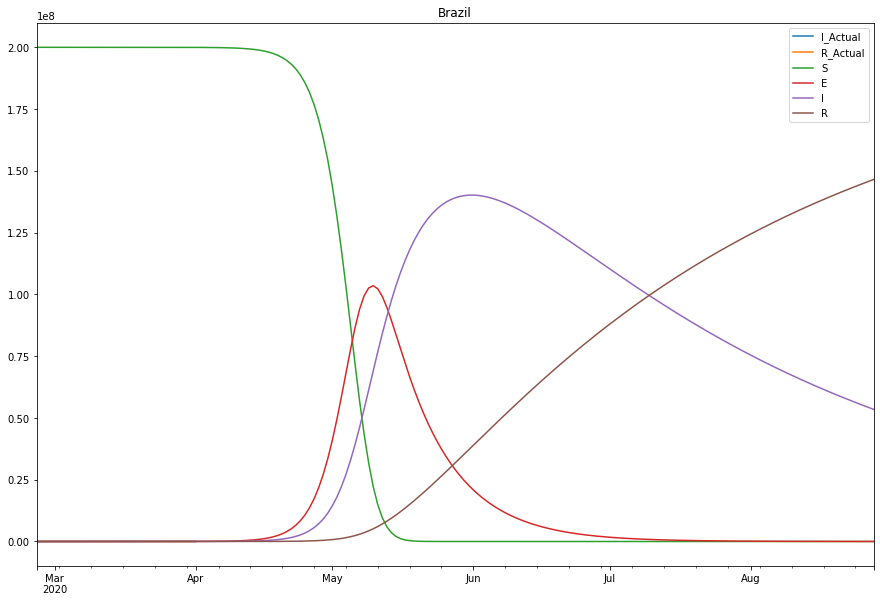

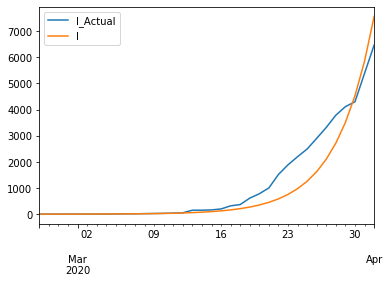

time: 931 ms


In [6]:
t1 = SEIR(
    country='Brazil', 
    N=200e6, 
    alpha=.9,
#    betaBounds = (0.0001, 0.4),
#    gammaBounds = (0.01, 0.1),
    betaBounds = (0.0001, 2.0),
    gammaBounds = (0.0001, 2.0),
    incubationPeriod=12,
    forceE0 = 0,
         )
t1.train()
t1.main_plot()
t1.I_fit_plot()

Beta:0.4 Gamma:0.01
R0:40.0
Predicting with Beta:0.4 Beta2: 0.4 Gamma:0.01 Sigma:0.08333333333333333


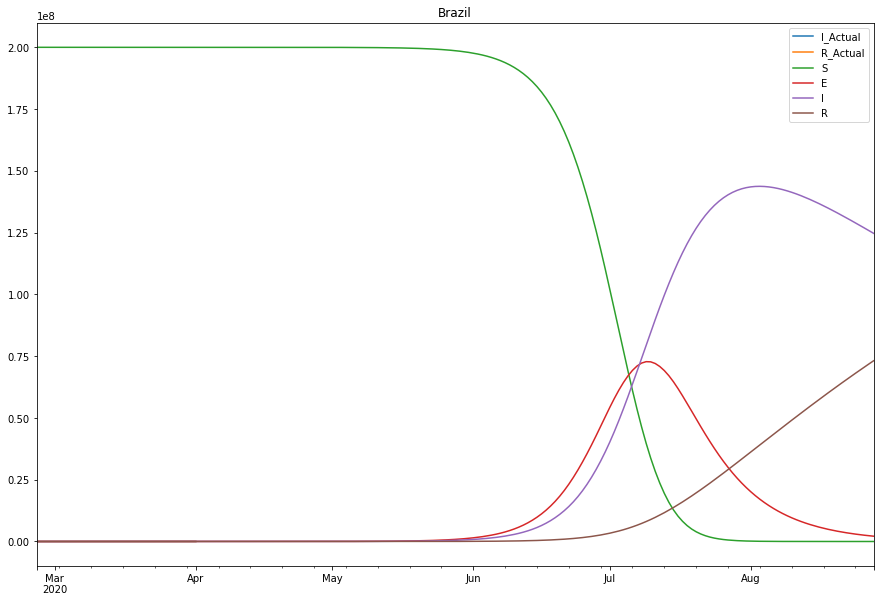

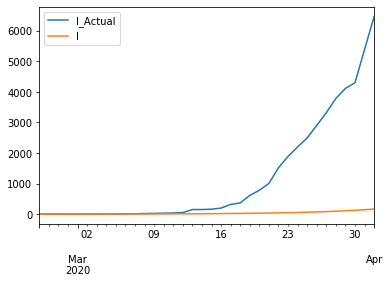

time: 605 ms


In [3]:
t1 = SEIR(
    country='Brazil', 
    N=200e6, 
    alpha=.9,
    betaBounds = (0.1, 0.4),
    gammaBounds = (0.01, 0.1),
    incubationPeriod=12,
    forceE0 = 0,
         )
t1.train()
t1.main_plot()
t1.I_fit_plot()

## Constrained optimization - SIR

Beta:0.32429692718352443 Gamma:0.07
R0:4.63281324547892
Predicting with Beta:0.32429692718352443 Beta2: 0.32429692718352443 Gamma:0.07


45418000.04750213

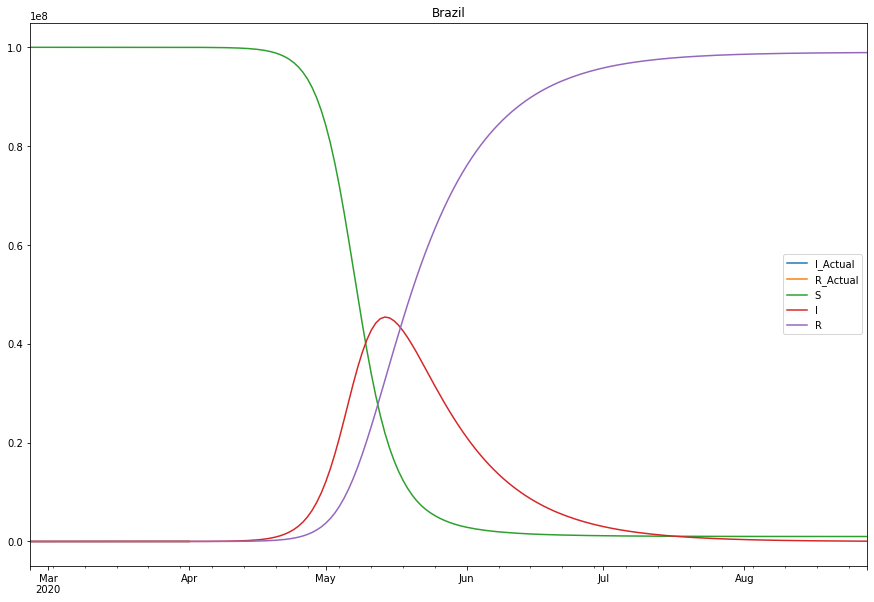

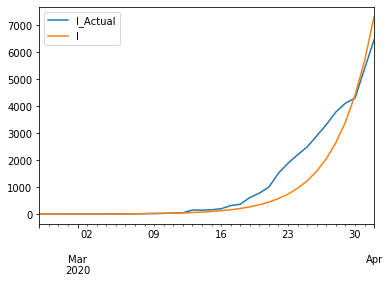

time: 651 ms


In [19]:
t1 = SIR('Brazil', 
                 N=100e6, 
                 alpha=0.7,
                 betaBounds = (0.1, 0.4),
                 gammaBounds = (0.07, 0.1),
                )
t1.train()
t1.main_plot()
t1.I_fit_plot()
t1.df.I.max()

Beta:0.27158418676245427 Gamma:0.07
R0:3.8797740966064893
Predicting with Beta:0.27158418676245427 Beta2: 0.27158418676245427 Gamma:0.07

Max:
393647.50943782233
Est:
59047.126415673345


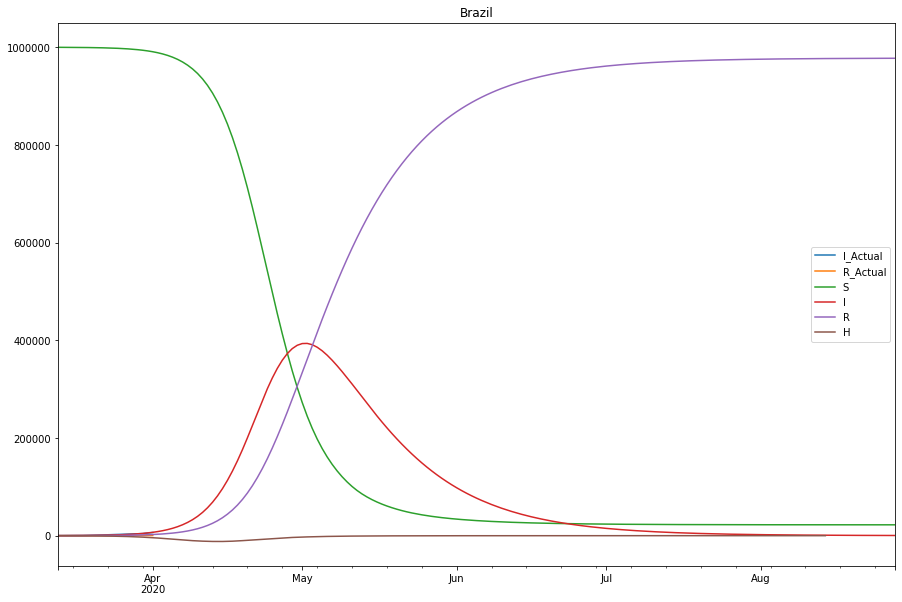

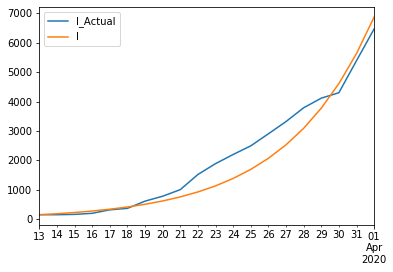

time: 583 ms


In [15]:
t1 = SIR('Brazil', 
         #N=200e6 * 15/230, 
         N=1e6,
         alpha=0.7,
         betaBounds = (0.1, 0.4),
         gammaBounds = (0.07, 0.1),
         nth = 100
                )
t1.train()
t1.main_plot()
t1.I_fit_plot()
print('\nMax:')
print(t1.df.I.max())
print('Est:')
print(t1.df.I.max()*.15)

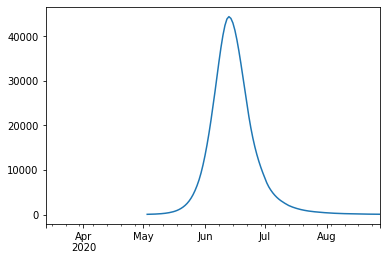

time: 167 ms


In [21]:
(t1.df['S'].shift(1)-t1.df['S']).shift(50).plot()
#t.df['hospDemand'] = ((self.df['S'] - self.df['S'].shift(1)) * self.hospRate).shift(-self.daysToHosp)
#self.df['hospExpire'] = - self.df['hospDemand'].shift(-self.daysToLeave)
#self.df['H'] = self.df['hospDemand'] - self.df['hospExpire']
#self.df.drop(['hospDemand', 'hospExpire'], axis=1, inplace=True)

In [12]:
t1.df['S'].min()

291178.1581772052

time: 2.97 ms


In [7]:
1.3e7

13000000.0

time: 2 ms


Perguntas:
* calibrar parametros na opt
* calibrar beta decay

* Qual o fim da quarentena? Quantos casos sao internação (15% dos confirmados). Leitos na italia (12.5 * 60e6 / 1e5)
* Lag de tempo de internação (novo tratamento caindo de 15 p/ 7)
* Contrai, x (7) dias depois interna, y(10) dias depois sai da internação
* Novos dados | tirar nth day
* fazer brasil e coreia do norte
* fazer dados simulados

Outros:
* prob de contagio usando varios paises
* momento otimo de quarentena
* time varying beta


US 45 MM influenza
https://www.cdc.gov/flu/about/burden/index.html


BR 65k respiradores e 55k leitos
https://exame.abril.com.br/brasil/ampliar-leitos-de-uti-e-meta-do-ministerio/

In [15]:
45 / 320

0.140625

time: 1.99 ms


In [16]:
9 / 320

0.028125

time: 2 ms


In [18]:
3e6 * .15

450000.0

time: 2 ms


In [33]:
pd.Series([1,2,3]).shift(-1)

0    2.0
1    3.0
2    NaN
dtype: float64

time: 3.99 ms


In [22]:
pd.Series([1,2,3]).shift(1)

0    NaN
1    1.0
2    2.0
dtype: float64

time: 3 ms
